## Random Forest Model for House Price Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
%matplotlib inline

print("TensorFlow v" + tf.__version__)
import ydf

TensorFlow v2.18.0


### Inspect and clean data

In [ ]:
train_file_path = "train.csv"
dataset_df = pd.read_csv(train_file_path).drop('Id', axis=1)
print(len(dataset_df), dataset_df.columns)
set(dataset_df.dtypes.tolist()) # data types are objects, int, float
# dataset_df.info()

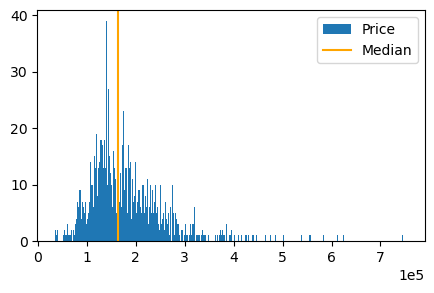

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(dataset_df['SalePrice'], bins=500, label='Price')
ax.axvline(np.quantile(dataset_df['SalePrice'], 0.5), color='orange', label='Median')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.legend()
plt.show()
# ydf supports all data types, no need to seperate numerical or categorical or misssing values. 

In [4]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


In [6]:
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print(len(train_ds_pd), 'for training;', len(valid_ds_pd), 'for test')

1034 for training; 426 for test


In [ ]:
# ydf does not need to seperate training and testing data sets; we use valid_ds_pd to test the final model
learner = ydf.RandomForestLearner(label="SalePrice", task=ydf.Task.REGRESSION)
model = learner.train(train_ds_pd)

In [ ]:
model.describe()
# num as root: number of root nodes using a specific feature.
# num nodes: number of nodes using a specific feature. 
# this cycle, the RMSE value is 31720.4

In [8]:
feature0 = [vi[1] for vi in model.variable_importances()['NUM_AS_ROOT']]
feature0_importance = [vi[0] for vi in model.variable_importances()['NUM_AS_ROOT']]
feature1 = [name for _, name in model.variable_importances()['INV_MEAN_MIN_DEPTH'][:20]]
feature2 = [name for _, name in model.variable_importances()['NUM_NODES'][:20]]
feature3 = [name for _, name in model.variable_importances()['SUM_SCORE'][:20]]
feature_all = set(feature0 + feature1 + feature2 + feature3)
# use these features to fine tune model

In [9]:
evaluation = model.evaluate(valid_ds_pd) # ydf uses Out of Bag predication here
predictions = model.predict(valid_ds_pd.drop('SalePrice', axis=1))

Model loaded with 300 root(s), 98194 node(s), and 74 input feature(s).
Engine "RandomForestOptPred" built


In [ ]:
evaluation.RMSE

Evaluation()

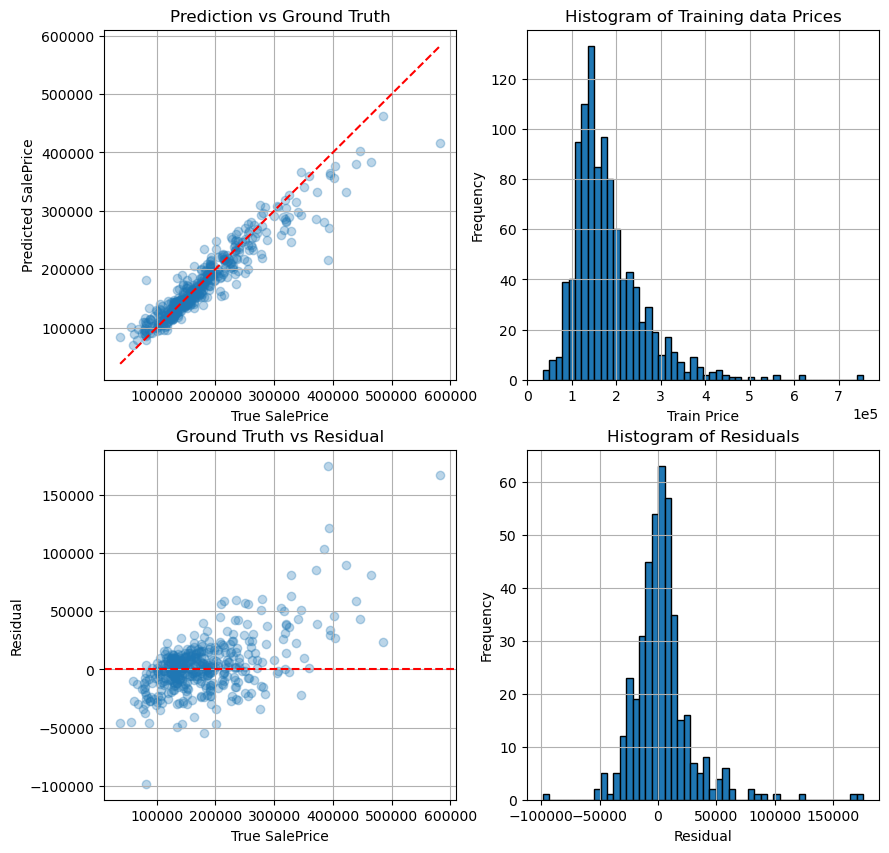

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
y_train = train_ds_pd['SalePrice']
y_true = valid_ds_pd['SalePrice']
y_pred = model.predict(valid_ds_pd)
residuals = np.array(y_true) - np.array(y_pred)

axs[0, 0].scatter(y_true, y_pred, alpha=0.3)
axs[0, 0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
axs[0, 0].set_title("Prediction vs Ground Truth")
axs[0, 0].set(xlabel = "True SalePrice", ylabel = "Predicted SalePrice")
axs[0, 0].grid()

axs[0, 1].hist(y_train, bins=50, edgecolor='k')
axs[0, 1].set_title('Histogram of Training data Prices')
axs[0, 1].set(xlabel = "Train Price", ylabel = "Frequency")
axs[0, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

axs[0, 1].grid()
# axs[0, 1].scatter(y_pred, residuals, alpha=0.3)
# axs[0, 1].axhline(0, color='r', linestyle = '--')
# axs[0, 1].set_title('Prediction vs Residual')
# axs[0, 1].set(xlabel = "Predicted SalePrice", ylabel = "Residual")
# axs[0, 1].grid()

axs[1, 0].scatter(y_true, residuals, alpha=0.3)
axs[1, 0].axhline(0, color = 'r', linestyle='--')
axs[1, 0].set_title('Ground Truth vs Residual')
axs[1, 0].set(xlabel = "True SalePrice", ylabel = "Residual")
axs[1, 0].grid()

axs[1, 1].hist(residuals, bins=50, edgecolor='k')
axs[1, 1].set_title('Histogram of Residuals')
axs[1, 1].set(xlabel = "Residual", ylabel = "Frequency")
axs[1, 1].grid()


### Fine tuning and data transformation
The plot above shows that the prediction below 300,000 is relatively precise. For values above, the prediction is poorer, likely because the training samples are not as much (distributional imbalance). In the below section, I try to handle the imbalance with:
- transform data (e.g. log-transform right-skewed price)
- Residual modeling (round1 of gradient boosting)
- feature engineering

In [ ]:
dataset_df["Log_SalePrice"] = np.log1p(dataset_df["SalePrice"])
train_ds_pd["Log_SalePrice"] = np.log1p(train_ds_pd["SalePrice"].values)
valid_ds_pd["Log_SalePrice"] = np.log1p(valid_ds_pd["SalePrice"].values)

In [ ]:
learner_log = ydf.RandomForestLearner(label="Log_SalePrice", task=ydf.Task.REGRESSION)
model_log = learner_log.train(train_ds_pd.drop('SalePrice', axis=1))
evaluation_log = model_log.evaluate(valid_ds_pd.drop('SalePrice', axis=1))
evaluation_log.rmse

In [90]:
from sklearn.metrics import root_mean_squared_error
result = root_mean_squared_error(y_true, y_pred)
print(result) 

27637.48265890953


#### segmented modeling

- since the data shows non-stationarity (check if there are different features for sales price above 300,000)


In [ ]:
low_price_train = train_ds_pd[train_ds_pd["SalePrice"] < 300000]
high_price_train = train_ds_pd[train_ds_pd["SalePrice"] >= 300000]
train_ds_pd['PriceGroup'] = train_ds_pd['SalePrice'].apply(lambda x: 'Low' if x < 300000 else 'High')
valid_ds_pd['PriceGroup'] = valid_ds_pd['SalePrice'].apply(lambda x: 'Low' if x < 300000 else 'High')

In [ ]:
model_log_high = learner_log.train(high_price_train.drop('SalePrice', axis=1))
# evaluation_log = model_log.evaluate(valid_ds_pd)
# evaluation_log.rmse

In [ ]:
feature0_high = [vi[1] for vi in model_log_high.variable_importances()['NUM_AS_ROOT']]
feature1_high = [name for _, name in model_log_high.variable_importances()['INV_MEAN_MIN_DEPTH'][:20]]
feature2_high = [name for _, name in model_log_high.variable_importances()['NUM_NODES'][:20]]
feature3_high = [name for _, name in model_log_high.variable_importances()['SUM_SCORE'][:20]]
feature_all_high = set(feature0_high + feature1_high + feature2_high + feature3_high)

In [ ]:
model_log_high.describe()

In [113]:
feature_all_high - feature_all,  feature_all-feature_all_high
# among the differences, 'BsmtExposure' and 'MasVnrType' are of higher importance in the higher priced house models. Look further into it.

({'BsmtExposure', 'LotShape', 'MasVnrArea', 'MasVnrType'},
 {'BsmtFinType1',
  'BsmtQual',
  'Exterior2nd',
  'FireplaceQu',
  'Fireplaces',
  'GarageType',
  'GarageYrBlt',
  'YearRemodAdd'})

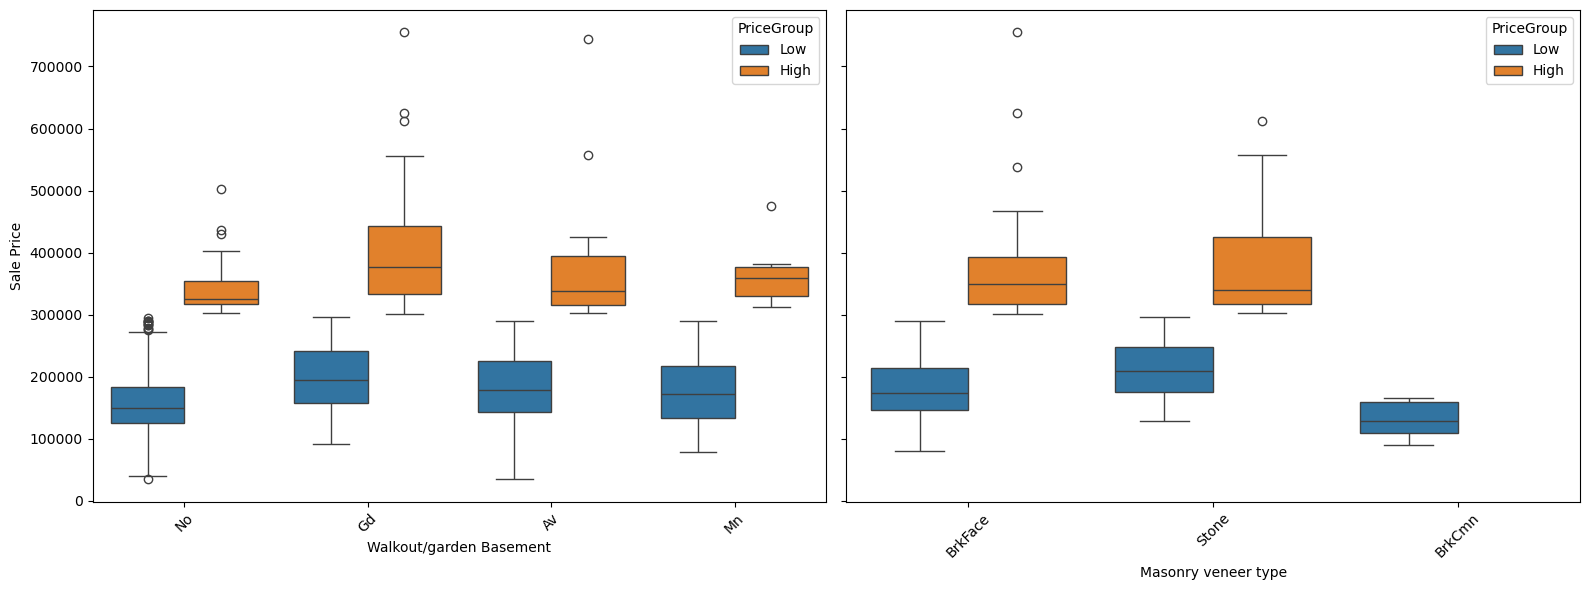

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.boxplot(data=train_ds_pd, x='BsmtExposure', y='SalePrice', hue='PriceGroup', ax=axes[0])
# axes[0].set_title('Sale Price by BsmtExposure (High vs. Low)')
axes[0].set_xlabel('Walkout/garden Basement')
axes[0].set_ylabel('Sale Price')
axes[0].tick_params(axis='x', rotation=45)
sns.boxplot(data=train_ds_pd, x='MasVnrType', y='SalePrice', hue='PriceGroup', ax=axes[1])
axes[1].set_xlabel('Masonry veneer type')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

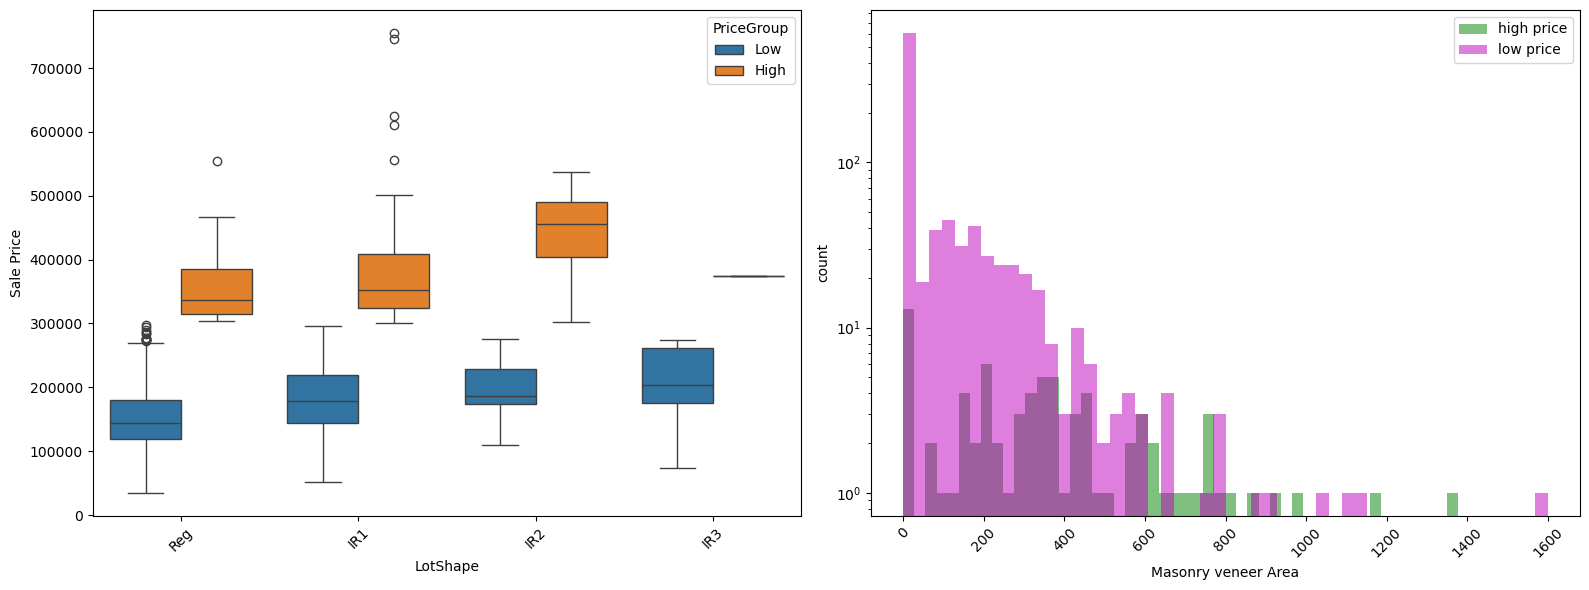

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=train_ds_pd, x='LotShape', y='SalePrice', hue='PriceGroup', ax=axes[0])
axes[0].set_xlabel('LotShape')
axes[0].set_ylabel('Sale Price')
axes[0].tick_params(axis='x', rotation=45)
axes[1].hist(high_price_train['MasVnrArea'], bins=50, alpha=0.5, color='g', label='high price')
axes[1].hist(low_price_train['MasVnrArea'], bins=50, alpha=0.5, color = 'm', label='low price')
axes[1].set_xlabel('Masonry veneer Area')
axes[1].set_ylabel('count')
axes[1].semilogy()
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
train_ds_pd['IsBrk'] = (train_ds_pd['MasVnrType']=='BrkCmn').astype(int) # if it's BrkCmn, likely low price
train_ds_pd['IsIR3'] = (train_ds_pd['LotShape']=='IR3').astype(int) # if it's IR3, likely low price. 
train_ds_pd['IsBrkANDIR3'] = train_ds_pd['IsBrk']*train_ds_pd['IsIR3'] 

valid_ds_pd['IsBrk'] = (valid_ds_pd['MasVnrType']=='BrkCmn').astype(int) # if it's BrkCmn, likely low price
valid_ds_pd['IsIR3'] = (valid_ds_pd['LotShape']=='IR3').astype(int) # if it's IR3, likely low price. 
valid_ds_pd['IsBrkANDIR3'] = valid_ds_pd['IsBrk']*valid_ds_pd['IsIR3'] 

In [ ]:
learner_gb = ydf.GradientBoostedTreesLearner(task=ydf.Task.REGRESSION, label="Log_SalePrice")
model_gb = learner_gb.train(train_ds_pd.drop('SalePrice',axis=1))


In [161]:
model_gb.evaluate(valid_ds_pd.drop('SalePrice', axis=1))

Evaluation()